# Project Report

# **Using age, cholesterol and heart rate to classify heart disease patients from Cleveland.**
#### Shreya Arora, Youssef Saleh, Zahra Vink.

### Introduction
The term heart (cardiovascular) disease describes a range of heart conditions that arise from problems with the heart and blood vessels. One of these is coronary artery disease, which is when the arteries supplying blood to the heart narrow. Many risk factors can increase the chance of developing this disease, including cholesterol levels and maximum heart rate (Cleveland Clinic, n.d.). Age is also a factor, with older people being more likely to be diagnosed with heart disease (Rogers et al., 2019).

High levels of cholesterol result in fatty deposits in blood vessels that clog them, making it difficult for enough blood to flow through the arteries. When these deposits break suddenly, they form a clot resulting in a heart attack or stroke. If a patient has heart disease, their maximum heart rate could significantly decrease (WebMD, 2002). 

The goal of this project will be to use these risk factors to classify patients based on likeliness to have heart disease.

The question we will be addressing is: **Is a new patient likely to have heart disease, based on age, cholesterol levels and maximum heart rate achieved?**

### Preliminary exploratory data analysis

In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

In [2]:
set.seed(1)
# reading the dataframe from URL, assigning col names and types
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"),
                           col_types = list("d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "f", "f", "d"))

# cleaning, wrangling data
cleveland_data[ cleveland_data == "?" ] <- NA

cleveland_clean <- cleveland_data %>%
                    mutate(diag = as.factor(ifelse(is.na(num), NA, (num > 0)))) %>%
                    mutate(sex = as.factor(as.integer(sex)), cp = as.factor(as.integer(cp)), 
                           fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
                           exang = as.factor(as.integer(exang)), thal = as.factor(as.integer(thal)),
                           ca = as.factor(as.integer(ca)), slope = as.factor(as.integer(slope))) %>%
                    mutate(num = as_factor(num))

#splitting dataframe into training, testing datasets
cleveland_split <- initial_split(cleveland_clean, prop = 3/4, strata = num)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,1,1,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,2,2,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,3,3,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,1,2,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,1,2,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0,FALSE


In [25]:
#summarizing to get min, max, mean of each predictor + total no. of rows per class
cleveland_summary <- cleveland_training %>%
                    group_by(diag) %>%
                    summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
                              min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol), 
                              min_thalach = min(thalach), max_thalach = max(thalach), mean_thalach = mean(thalach),
                              n_of_patients = n())

cleveland_summary

`summarise()` ungrouping output (override with `.groups` argument)



diag,min_age,max_age,mean_age,min_chol,max_chol,mean_chol,min_thalach,max_thalach,mean_thalach,n_of_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,29,74,52.71545,141,417,241.2439,96,202,157.6179,123
TRUE,35,77,56.72381,131,353,252.6857,90,182,139.4095,105


In [18]:
#plotting the training data
plot1 <- ggplot(cleveland_training, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "max heart rate reached", y = "cholesterol (mg/dl)", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

plot2 <- ggplot(cleveland_training, aes(x = age, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "age (years)", y = "cholesterol (mg/dl)", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

plot3 <- ggplot(cleveland_training, aes(x = age, y = thalach, color = diag)) +
                 geom_point() +
                 labs(x = "age (years)", y = "max heart rate reached", color = "diagnosis") +
                 scale_color_brewer(palette = "Set1")

plot1
plot2
plot3

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): unable to start device 'png'


plot without title

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): unable to start device 'png'


plot without title

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): unable to start device 'png'


plot without title

### Methods
We are using the processed.cleveland.data from the Heart Disease Database (originally collected from the Cleveland Clinic Foundation) to predict if a patient from Cleveland will have heart disease. The columns are as follows:
1. **age**: age
2. **sex**: sex (1 = male, 0 = female)
3. **cp**: chest pain type
4. **trestbps**: resting blood pressure in mmHg
5. **chol**: serum cholestoral in mg/dl
6. **fbs**: fasting blood sugar > 120 mg/dl? (1 = True, 0 = False)
7. **restecg**: resting electrocardiographic results
8. **thalach**: maximum heart rate achieved
9. **exang**: whether exercise induced angina (1 = True, 0 = False)
10. **oldpeak**: ST depression induced by exercise, relative to rest
11. **slope**: the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. **ca**: number of major vessels (0-3) colored by flourosopy
13. **thal**: (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. **num**: diagnosis of heart disease (1,2,3,4 = presence, 0 = no presence)

Each column is numeric-valued and there are 303 rows, with missing data represented as the string "?".

To clean the data, we changed all "?" values into NA. Since **num** uses integers to distinguish presence (1,2,3,4) from absence (0), and we want to determine *whether or not* a patient has heart disease, a new boolean column **diag** has been appended to narrow diagnoses down to TRUE or FALSE.

We used initial_split() to split our dataframe into 75% training and 25% testing data, stratifying for **diag**. We used only the training set for analysis.

To summarize our data, we grouped by **diag** then summarized for the minimum, maximum and mean of each of **age**, **chol** and **thalach**. We noticed that the mean age of patients with heart disease is higher, as well as their cholesterol. Their maximum heart rate achieved was lower, on average.

To visualize relationships in our data, we generated scatter plots of different numerical (non-factor) variables against eachother. This helped us identify the best predictors to use, which eneded up aligning with our initial research (see introduction). When plotting **chol** vs **thalach**, and coloring our points based on **diag**, we could see three clear regions of TRUE diagnoses, FALSE diagnoses and an region of mixing of the two. Similarly distinct distributions were seen when visualizing **age** vs **chol** and **age** vs **thalach**.

### Data Analysis

**Finding best K value**

Now our goal is to find the best value for the K-nearest neighbours, that provides us with the highest accuracy, and better predictions. We had already split the data into a training and testing set in the beginning, so in the code below we create a classifier and preform cross validation with 10 folds. 

In [5]:
set.seed(1)

# Performing Standardization 
cleveland_recipe <- recipe(diag ~ chol + thalach , data = cleveland_training) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

# Perform 10 fold-cross valdiation 
cleveland_vfold <- vfold_cv(cleveland_training, v = 10, strata = diag)

# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

gridvals <- tibble(neighbors = c(1:100))

# Create new workflow using new knn_tune 
knn_results <- workflow() %>%
      add_recipe(cleveland_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = cleveland_vfold, grid = gridvals) %>%
      collect_metrics()

#knn_results

! Fold01: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold03: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold06: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold09: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,mean
<int>,<dbl>
73,0.7038702
74,0.7038702
83,0.6987813
84,0.6987813
57,0.6949769
77,0.6947958


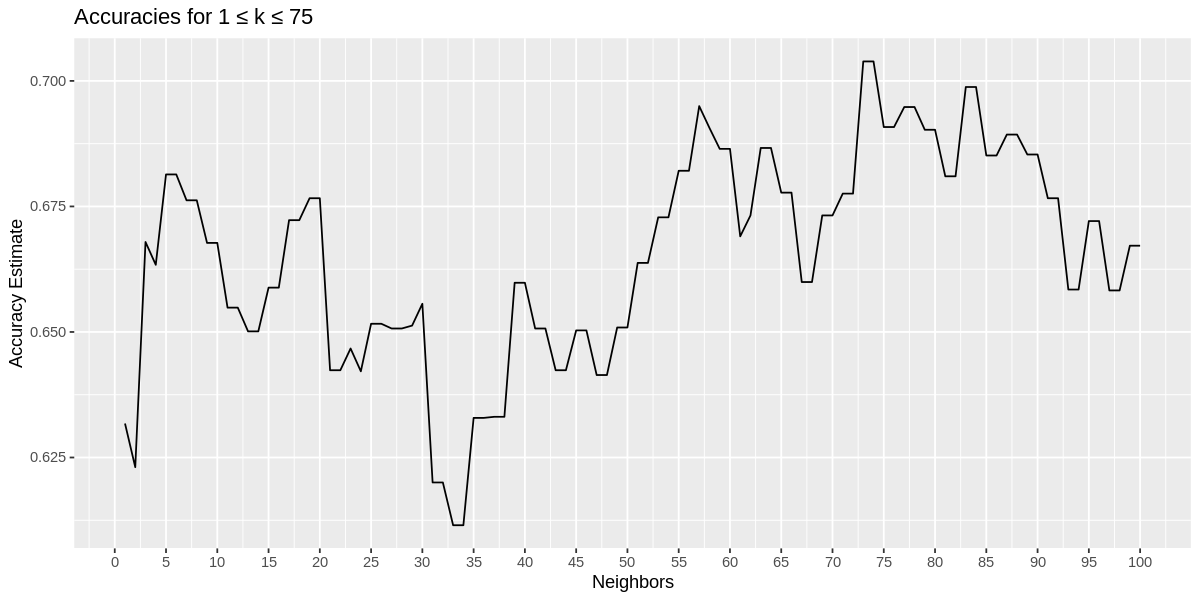

In [15]:
options(repr.plot.width = 10, repr.plot.height = 5)

#To find best k value filter for accuracies and graph
accuracies <- knn_results %>% 
      filter(.metric == "accuracy") %>%
      select(neighbors, mean) %>%
      arrange(desc(mean))

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      #geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 75") +
      scale_x_continuous(breaks = seq(0, 100, by = 5))  # adjusting the x-axis

accuracy_versus_k
head(accuracies)

Looking at the graph above, $k$ = 73 give us the best accuracy, at 70%

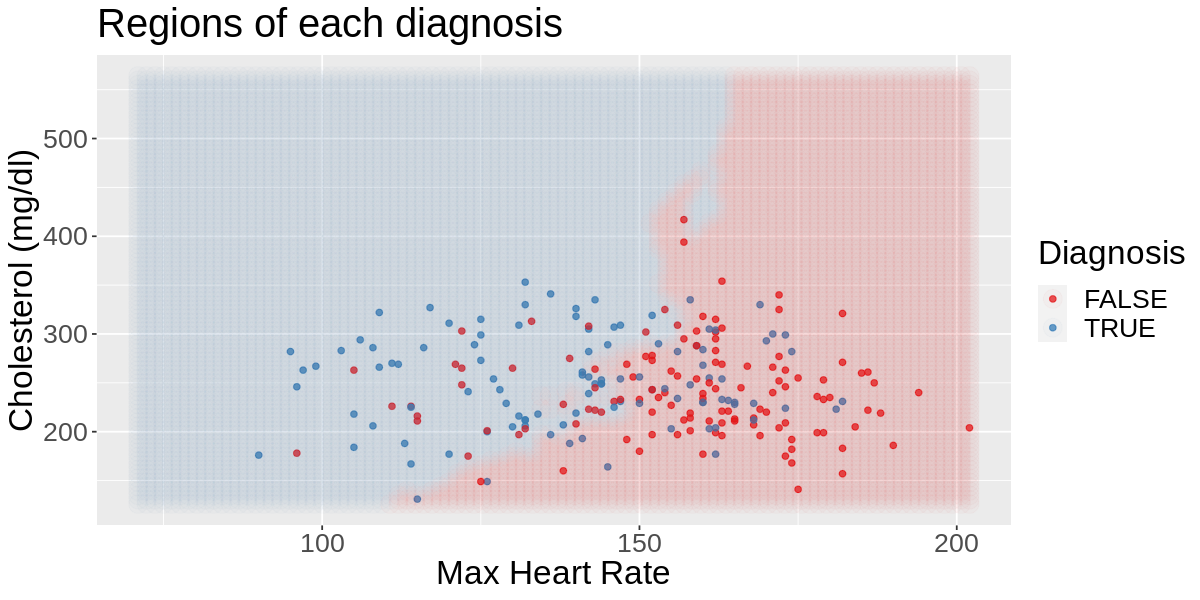

In [72]:
set.seed(1)

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 73)%>%
    set_engine("kknn")%>%
    set_mode("classification")

fit <- workflow()%>%
    add_recipe(cleveland_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = cleveland_training)

train_predictions <- predict(fit, cleveland_training)%>%
    bind_cols(cleveland_training)

thalach_grid <- seq(min(cleveland_clean$thalach), 
                max(cleveland_clean$thalach), 
                length.out = 100)

chol_grid <- seq(min(cleveland_clean$chol), 
                max(cleveland_clean$chol), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(thalach = thalach_grid, 
                                chol = chol_grid))

knnPredGrid <- predict(fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
                    rename(diag = .pred_class)


plot_results <- ggplot() + 
                geom_point(data = train_predictions, 
                mapping = aes(x = thalach, y = chol, color = diag), 
                alpha = 0.75) +
                geom_point(data = prediction_table, 
                           mapping = aes(x = thalach, 
                           y = chol, 
                           color = diag), 
                           alpha = 0.02, 
                           size = 5) +
                labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", 
                     color = "Diagnosis", 
                     title = "Regions of each diagnosis") +
                scale_color_brewer(palette = "Set1") +
                theme(text = element_text(size = 20))
plot_results

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
TRUE,56,0,2,140,294,0,2,153,0,1.3,2,1,2,0,FALSE
TRUE,64,1,1,110,211,0,2,144,1,1.8,2,1,2,0,FALSE
FALSE,43,1,4,150,247,0,0,171,0,1.5,1,1,2,0,FALSE
FALSE,69,0,1,140,239,0,0,151,0,1.8,1,3,2,0,FALSE
FALSE,59,1,4,135,234,0,0,161,0,0.5,2,1,3,0,FALSE
FALSE,42,1,4,140,226,0,0,178,0,0.0,1,1,2,0,FALSE


.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
FALSE,67,1,3,152,212,0,2,150,0,0.8,2,1,3,1,TRUE
FALSE,55,0,2,132,342,0,0,166,0,1.2,1,1,2,0,FALSE
FALSE,44,1,4,120,169,0,0,144,1,2.8,3,1,1,2,TRUE
FALSE,63,1,4,140,187,0,2,144,1,4.0,1,3,3,2,TRUE
TRUE,45,1,1,110,264,0,0,132,0,1.2,2,1,3,1,TRUE
FALSE,57,0,2,130,236,0,2,174,0,0.0,2,4,2,1,TRUE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.68


          Truth
Prediction FALSE TRUE
     FALSE    33   16
     TRUE      8   18

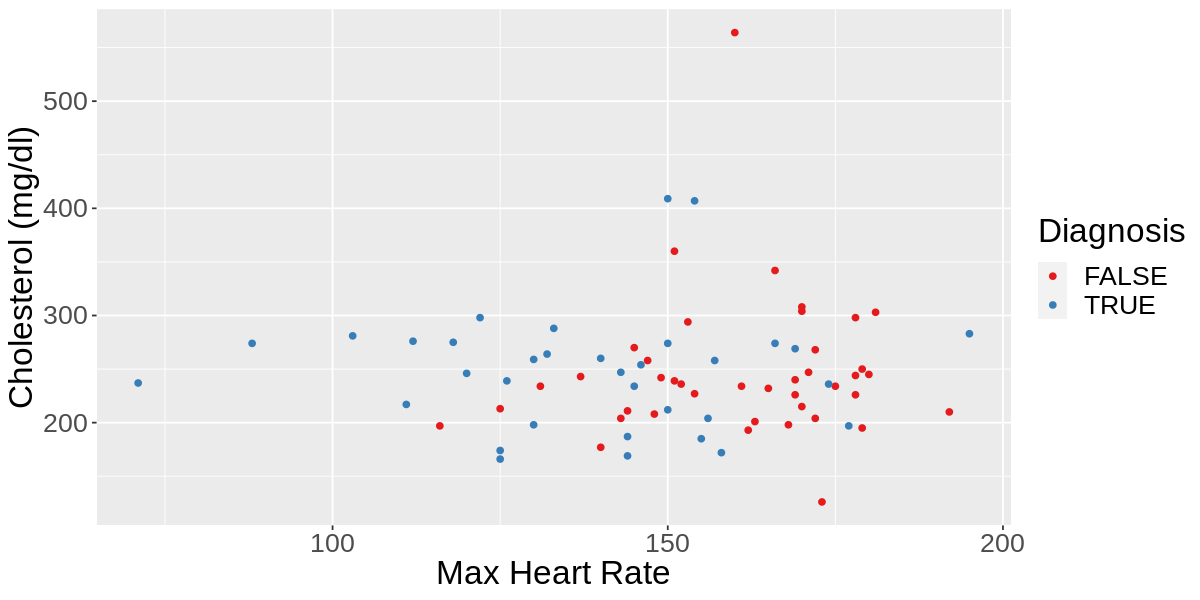

In [73]:
set.seed(1)

#build the model
#model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 73)%>%
    set_engine("kknn")%>%
    set_mode("classification")

#workflow
fit<- workflow()%>%
    add_recipe(cleveland_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = cleveland_training)

#predict
predictions<- predict(fit, cleveland_testing)%>%
    bind_cols(cleveland_testing)

head(predictions)
tail(predictions)

#find the accuracy of the predictions
metrics<- predictions %>%
    metrics(truth = diag, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<- predictions %>%
    conf_mat(truth = diag, estimate = .pred_class)
conf_mat

#visualizing results

plot_results <- ggplot(predictions, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", color = "Diagnosis") +
                 ggtitle("Predictions")+
                 scale_color_brewer(palette = "Set1")+
                 theme(text = element_text(size = 20))
plot_results